<a href="https://colab.research.google.com/github/sainithinkatta/deep_learning_class/blob/main/HW2_formal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 2 - Convolutional Neural Network and Recurrent Neural Networks**

In this homework, you are required to build a convolutional neural network a recursive neural network for image classification, possibly with some advanced training tips.

## **About the Dataset**

The dataset used here is Fashion-MNIST, a collection of food images in 10 classes.

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

## **Import Packages**

First, we need to import packages that will be used later.

In this homework, we highly rely on **torchvision**, a library of PyTorch.

In [ ]:
# Import necessary packages.
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from torch.utils.data import (DataLoader,)  # Gives easier dataset managment and creates mini batches
import torchvision  # torch package for vision related things
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
from PIL import Image

# This is for the progress bar.
from tqdm.auto import tqdm

%matplotlib inline

## **Dataset, Data Loader, and Transforms**

Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Here, since our data are stored in folders by class labels, we can directly apply **torchvision.datasets.DatasetFolder** for wrapping data without much effort.

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Transforms
my_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

# Download the dataset
train_dataset = datasets.FashionMNIST(
    root='/content/drive/MyDrive/dataset/FashionMNIST', train=True, transform=my_transforms, download=True
)
val_dataset = datasets.FashionMNIST(
    root='/content/drive/MyDrive/dataset/FashionMNIST', train=False, transform=my_transforms, download=True
)
test_dataset = datasets.FashionMNIST(
    root='/content/drive/MyDrive/dataset/FashionMNIST', train=False, transform=my_transforms, download=True
)

# Load Data
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 26.4M/26.4M [00:01<00:00, 13.3MB/s]


Extracting /content/drive/MyDrive/dataset/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/dataset/FashionMNIST/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]


Extracting /content/drive/MyDrive/dataset/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/dataset/FashionMNIST/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.88MB/s]


Extracting /content/drive/MyDrive/dataset/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/dataset/FashionMNIST/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 24.6MB/s]

Extracting /content/drive/MyDrive/dataset/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/dataset/FashionMNIST/FashionMNIST/raw



## Data Visulization

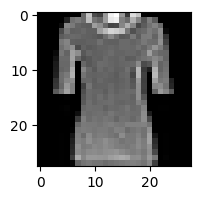

In [ ]:
# Random pick a sample to plot
sample = next(iter(train_loader))
imgs, lbls = sample

# Plot the sample
plt.figure(figsize=(2,2))
grid = torchvision.utils.make_grid(nrow=20, tensor=imgs[1])
plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');

## **Convolutional Neural Network**

###  CNN Model (7pts)

In [ ]:
# Simple CNN
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(CNN, self).__init__()
        #(1pt)TODO: Fill the missing with correct number
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=8, # hint: in_channels of next conv layer
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )

        #(1pt)TODO: Use a Max Pooling layer with kernel size = 2 and stride =2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        #(1pt)TODO: Fill the missing with correct number
        self.fc1 = nn.Linear(784, num_classes) # hint: feature channels * length * width

    def forward(self, x):
        x = self.conv1(x) #(1pt)TODO: Use conv1 layer defined above
        x = F.relu(x) #(1pt)TODO: Use relu layer
        x = self.pool(x) #(1pt)TODO: Use pooling layer defined above
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x) #(1pt)TODO: Use fully connection layer defined above
        return x

### Hyperparameters, Data loader and Loss (1pt)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
learning_rate = 1e-4
batch_size = 64
num_epochs = 10 # You may change number of epochs here. 10 epochs may take up to 10 minutes for training.

# Load pretrain model & you may modify it
model = CNN(in_channels=1, num_classes=10)
model.classifier = nn.Sequential(nn.Linear(512, 100), nn.ReLU(), nn.Linear(100, 10))
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss() # (1pt)TODO: Use CrossEntropy as loss criterion
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


### Training

In [ ]:
# Train Network
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())
        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Loss at epoch {epoch + 1} is {sum(losses)/len(losses):.5f}")

Loss at epoch 1 is 1.14332
Loss at epoch 2 is 0.63543
Loss at epoch 3 is 0.55731
Loss at epoch 4 is 0.50998
Loss at epoch 5 is 0.47696
Loss at epoch 6 is 0.45257
Loss at epoch 7 is 0.43406
Loss at epoch 8 is 0.41908
Loss at epoch 9 is 0.40738
Loss at epoch 10 is 0.39713


### Check Accuracy

In [ ]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    if loader.dataset.train:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )

    model.train()

check_accuracy(train_loader, model)
check_accuracy(val_loader, model)

Checking accuracy on training data
Got 51627 / 60000 with accuracy 86.05
Checking accuracy on test data
Got 8482 / 10000 with accuracy 84.82


## **A simple Recurrent Neural Networks, GRU, LSTM on the MNIST dataset**


### Recurrent Neural Networks (2pts)

In [ ]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1) # (1pt)TODO: Reshape the output

        # Decode the hidden state of the last time step
        out = self.fc(out) # (1pt)TODO: Use fully connected laers above
        return out

### Gated Recurrent Unit Recurrent Neural Networks(GRU)

In [ ]:
# Recurrent neural network with GRU (many-to-one)
class RNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN_GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.gru(x, h0)
        out = out.reshape(out.shape[0], -1)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out

### Long Short-Term Memory (4pts)

In [ ]:
# Recurrent neural network with LSTM (many-to-one)

# Compared the model above and fill the following missings
class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True
          ) # (1pt)TODO: Define LSTM layer
        self.fc = nn.Linear(
            hidden_size * sequence_length,
            num_classes
          ) # (1pt)TODO: Define fc layer

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(
            x, (h0, c0)
        )  # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = out.reshape(out.shape[0], -1) # (1pt)TODO: Reshape the output

        # Decode the hidden state of the last time step
        out = self.fc(out) # (1pt)TODO: Use fc layer above
        return out

### Training (1pt)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_size = 28
hidden_size = 256
num_layers = 3
num_classes = 10
sequence_length = 28
learning_rate = 0.005
batch_size = 64
num_epochs = 3

# Load Data
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# Initialize network (try out just using simple RNN, or GRU, and then compare with LSTM)
model_RNN = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
model_GRU = RNN_GRU(input_size, hidden_size, num_layers, num_classes).to(device)
model_LSTM = RNN_LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_RNN = optim.Adam(model_RNN.parameters(), lr=learning_rate)
optimizer_GRU = optim.Adam(model_GRU.parameters(), lr=learning_rate)
optimizer_LSTM = optim.Adam(model_LSTM.parameters(), lr=learning_rate)


# Train Network
# RNN
print('RNN Training')
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device).squeeze(1)
        targets = targets.to(device=device)

        # forward
        scores_RNN = model_RNN(data)
        loss_RNN= criterion(scores_RNN, targets)

        # backward
        optimizer_RNN.zero_grad()
        loss_RNN.backward()

        # gradient descent update step/adam step
        optimizer_RNN.step()

# RNN_GRU
print('RNN_GRU Training')
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device).squeeze(1)
        targets = targets.to(device=device)

        # forward
        scores_GRU = model_GRU(data)
        loss_GRU= criterion(scores_GRU, targets)

        # backward
        optimizer_GRU.zero_grad()
        loss_GRU.backward()

        # gradient descent update step/adam step
        optimizer_GRU.step()

# RNN_LSTM
print('RNN_LSTM Training')
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device).squeeze(1)
        targets = targets.to(device=device)

        # forward
        scores_LSTM = model_LSTM(data)
        loss_LSTM= criterion(scores_LSTM, targets) # (1pt)TODO: Calculate loss by using criterion

        # backward
        optimizer_LSTM.zero_grad()
        loss_LSTM.backward()

        # gradient descent update step/adam step
        optimizer_LSTM.step()



RNN Training


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

RNN_GRU Training


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

RNN_LSTM Training


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

### Check Accuracy (1pt)

In [ ]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0

    # Set model to eval
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device).squeeze(1)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum().item() # (1pt)TODO: Count the number of correct prediction
            num_samples += predictions.size(0)

    # Toggle model back to train
    model.train()
    return num_correct / num_samples


print(f"RNN_Accuracy on training set: {check_accuracy(train_loader, model_RNN)*100:2f}")
print(f"RNN_Accuracy on test set: {check_accuracy(test_loader, model_RNN)*100:.2f}")
print(f"RNN_GRU_Accuracy on training set: {check_accuracy(train_loader, model_GRU)*100:2f}")
print(f"RNN_GRU_Accuracy on test set: {check_accuracy(test_loader, model_GRU)*100:.2f}")
print(f"RNN_LSTM_Accuracy on training set: {check_accuracy(train_loader, model_LSTM)*100:2f}")
print(f"RNN_LSTM_Accuracy on test set: {check_accuracy(test_loader, model_LSTM)*100:.2f}")

RNN_Accuracy on training set: 21.431667
RNN_Accuracy on test set: 21.35
RNN_GRU_Accuracy on training set: 89.613333
RNN_GRU_Accuracy on test set: 88.24
RNN_LSTM_Accuracy on training set: 90.300000
RNN_LSTM_Accuracy on test set: 88.64
